In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Download Data

In [2]:
df_train = pd.read_csv("data/train.csv")
df_kaggle = pd.read_csv("data/test.csv")

# Delete features first features

#### Count Nan Values

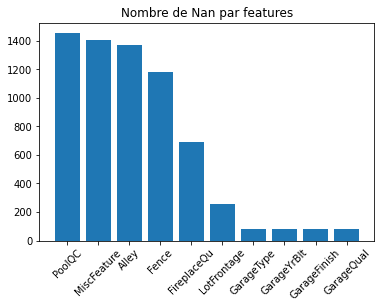

In [3]:
nb_nan = {}
for column in df_train:
    nb_nan[column] = df_train[column].isnull().sum()
nb_nan = {k: v for k, v in sorted(nb_nan.items(), key=lambda item: item[1], reverse=True)}
x = [column for column in nb_nan.keys()]
y = [nan for nan in nb_nan.values()]
plt.bar(x[:10], y[:10])
plt.xticks(rotation=45)
plt.title("Nombre de Nan par features")
plt.show()

#### Delete column with more than 50% Nan Values

In [4]:
x_train = df_train
x_train = x_train.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'SalePrice'], 1)
y_train = df_train['SalePrice']

x_kaggle = df_kaggle
x_kaggle = x_kaggle.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], 1)

# Preprocessing

#### Replace Nan values in selected features

In [5]:
def replace_nan_values(data):
    for column in data:
        if data[column].isnull().sum() > 0:
            if data[column].dtype == 'object':
                data[column] = x_train[column].fillna(x_train[column].value_counts().index.tolist()[0])
            elif data[column].dtype in ['float64', 'int64']:
                data[column] = x_train[column].fillna(x_train[column].mean())

In [6]:
for index, data in enumerate([x_train, x_kaggle]):
    replace_nan_values(data)

#### Features correlation

In [7]:
cor = df_train.corr()
cor_target = abs(cor["SalePrice"])
relevant_features = cor_target[cor_target>0.5]
relevant_features

OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
TotalBsmtSF     0.613581
1stFlrSF        0.605852
GrLivArea       0.708624
FullBath        0.560664
TotRmsAbvGrd    0.533723
GarageCars      0.640409
GarageArea      0.623431
SalePrice       1.000000
Name: SalePrice, dtype: float64

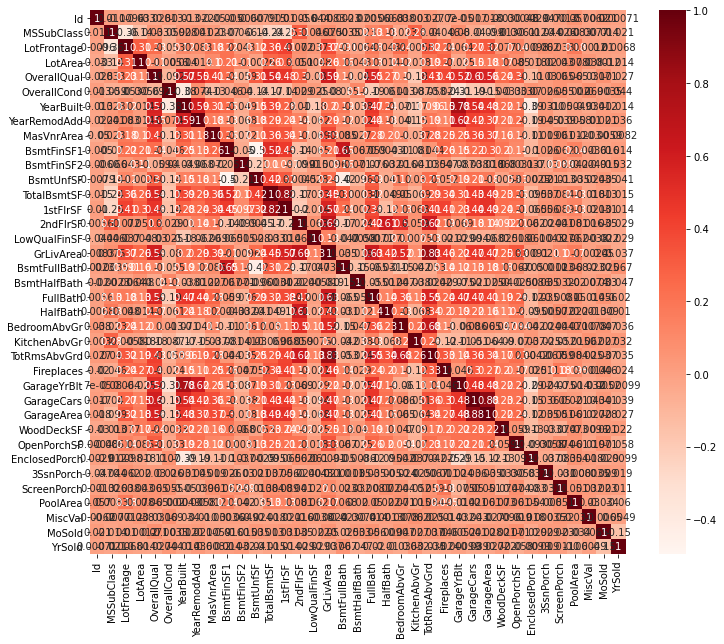

In [8]:
plt.figure(figsize=(12,10))
cor = x_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### Create new features

In [9]:
x_train['TotalSF'] = x_train['TotalBsmtSF'] + x_train['1stFlrSF'] + x_train['2ndFlrSF']

x_train['Total_Bathrooms'] = (x_train['FullBath'] + (0.5 * x_train['HalfBath']) +
                               x_train['BsmtFullBath'] + (0.5 * x_train['BsmtHalfBath']))

x_train['Total_porch_sf'] = (x_train['OpenPorchSF'] + x_train['3SsnPorch'] +
                              x_train['EnclosedPorch'] + x_train['ScreenPorch'] +
                              x_train['WoodDeckSF'])

#### One Hot Encode string features

In [10]:
label_encoder = LabelEncoder()
x_train = x_train.apply(label_encoder.fit_transform)
x_kaggle = x_kaggle.apply(label_encoder.fit_transform)

#### Split training dataset

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.33, random_state=0)

# Create models

#### Create scikit learn instance of models

In [12]:
models = []

models.append(("KNeighborsRegressor", KNeighborsRegressor(n_neighbors=10)))
models.append(("LinearRegression", LinearRegression()))
models.append(("Ridge", Ridge(alpha=0.2)))
models.append(("Lasso", Lasso(alpha=0.2)))
models.append(("DecisionTreeRegressor", DecisionTreeRegressor(random_state=0, max_depth=8)))
models.append(("RandomForestregressor",RandomForestRegressor(random_state=0, max_depth=8)))

# Evaluate models

#### Calculate differents result scores

In [13]:
def score_model(x_train, y_train, x_test, y_test, model, name):
    scores = []
    model.fit(x_train, y_train)
    scores.append(name)
    scores.append(model.score(x_train, y_train))
    scores.append(model.score(x_test, y_test))
    
    y_pred = model.predict(x_test)
    y_pred = abs(y_pred)
    scores.append(round(mean_squared_log_error(y_test, y_pred), 4))
    return scores

In [14]:
scores = []
for name, model in models:
    score = score_model(x_train, y_train, x_test, y_test, model, name)
    scores.append(score)

/home/mael/envs_python/machine_learning/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 371401123019.75507, tolerance: 608709788.7765387
  model = cd_fast.enet_coordinate_descent(


#### Show scores

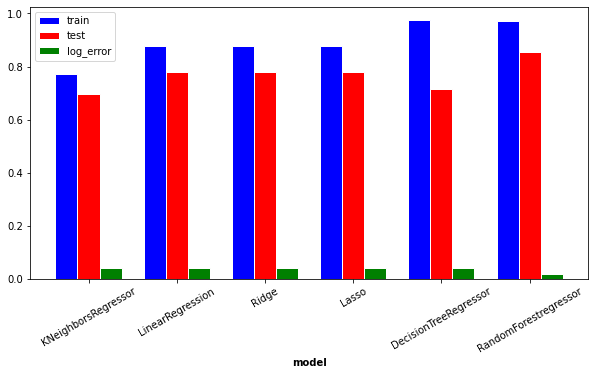

In [15]:
labels = [x[0] for x in scores]
train = [x[1] for x in scores]
test = [x[2] for x in scores]
log_error = [x[3] for x in scores]

bar_width = 0.25

r1 = np.arange(len(train))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]


plt.figure(figsize=(10,5))
plt.bar(r1, train, color='blue', width=bar_width, edgecolor='white', label='train')
plt.bar(r2, test, color='red', width=bar_width, edgecolor='white', label='test')
plt.bar(r3, log_error, color='green', width=bar_width, edgecolor='white', label='log_error')

plt.xlabel('model', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(train))], labels, rotation=30)

plt.legend()
plt.show()

# Ameliorate models

In [16]:
def feature_importance(model):
    n_features = x_train.shape[1]
    plt.figure(figsize=(5,50))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), [column for column in x_train])
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.ylim(-1, n_features)

# Save Kaggle prediction

In [17]:
# rfc = RandomForestRegressor(random_state=0, max_depth=8)
# rfc.fit(x_train, y_train)

In [18]:
# feature_importance(rfc)

In [19]:
# kaggle_pred = rfc.predict(x_kaggle)

In [20]:
# kaggle_pred = pd.DataFrame(kaggle_pred)

In [21]:
# kaggle_pred["Id"] = df_kaggle["Id"]

In [22]:
# kaggle_pred.columns = ['SalePrice', "Id"]

In [23]:
# kaggle_pred = kaggle_pred.reindex(sorted(kaggle_pred.columns), axis=1)

In [24]:
# kaggle_pred["SalePrice"] = kaggle_pred["SalePrice"].abs()

In [25]:
# kaggle_pred.to_csv("pred_it_01", index=False)